### Import Libraries

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

### Data Collection & Preprocessing

In [2]:
data=pd.read_csv('Emotions_training.csv')

In [3]:
# Filtering out rows where the 'text' column is not null
data = data[pd.notnull(data['text'])]

In [4]:
# Calculating the total number of words in the 'text' column
total_words = data['text'].str.split().str.len().sum()

In [5]:
print(total_words)

306661


#### Lower Case

In [6]:
data["text"] = data["text"].str.lower()

#### Removing links

In [7]:
data['text'] = data['text'].fillna('')

In [8]:
no_url=[]
for sentence in data["text"]:
    no_url.append(re.sub(r"http\S+", "", sentence))
data["text"]=no_url

#### Remove next lines

In [9]:
data['text'] = data['text'].str.replace('\n', '')

#### Removing words containing numbers

In [10]:
pattern = r'\b\w*\d\w*\b'
def remove_words_with_numbers(text):
    return re.sub(pattern, '', text)
data['text'] = data['text'].apply(remove_words_with_numbers)

#### Removing extra spaces

In [11]:
data['text'] = data['text'].apply(lambda x: ' '.join(x.split()))

#### Removing special characters

In [12]:
no_special_char=[]
for sentence in data.text:
    no_special_char.append(re.sub('[^A-Za-z0-9]+', ' ', sentence))
data["text"]=no_special_char

#### Removal of stop words

In [13]:
stop_words = set(stopwords.words('english'))

In [14]:
def remove_stopwords(text):
    tokens = text.split()
    filtered_text = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

In [15]:
data['text'] = data['text'].apply(remove_stopwords)

#### Stemming

In [16]:
stemmer = PorterStemmer()

In [17]:
def stem_text(text):
    # Initialize Porter Stemmer
    stemmer = PorterStemmer()
    # Tokenize the text and apply stemming to each word
    stemmed_words = [stemmer.stem(word) for word in word_tokenize(text)]
    # Join the stemmed words back into a sentence
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

In [18]:
data['text'] = data['text'].apply(stem_text)

#### Lemmatization

In [19]:
nlp = spacy.load('en_core_web_sm')

In [20]:
def lemmatize_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract lemmatized tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    # Join the lemmatized tokens into a sentence
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [21]:
data['text'] = data['text'].apply(lemmatize_text)

In [22]:
data['text'].head()

0                                   do not feel humili
1    go feel hopeless damn hope around someon care ...
2                I m grab minut post feel greedi wrong
3       ever feel nostalg fireplac know still properti
4                                         feel grouchi
Name: text, dtype: object

In [23]:
# Calculating the total number of words in the 'text' column after text preprocessing
total_words = data['text'].str.split().str.len().sum()

In [24]:
print(total_words)

154623


In [25]:
#Class Distribution
data['label'].value_counts()

label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

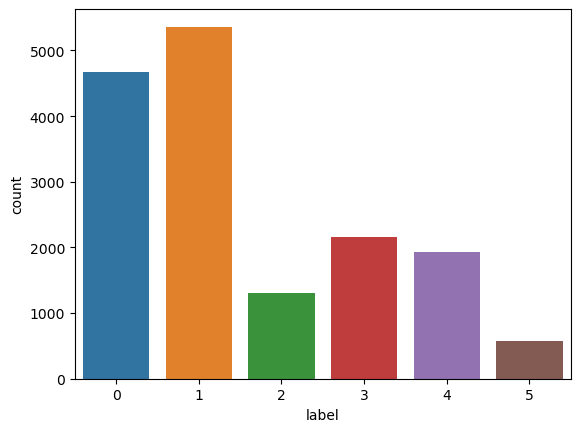

In [26]:
sns.countplot(x='label',data=data)

### Vectorization

In [27]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['label']

### Split the data into test and train sets

In [28]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) 

In [29]:
X_train,X_val,y_train,y_val=train_test_split(X_train_temp,y_train_temp,test_size=0.10,random_state=42)

### SMOTE Algorithm

In [30]:
counter=Counter(y_train)
print('Befor:',counter)

Befor: Counter({1: 3915, 0: 3347, 3: 1572, 4: 1382, 2: 896, 5: 408})


In [31]:
sm = SMOTE(random_state = 2) 
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [32]:
counter=Counter(y_train_sm)

In [33]:
print('After:',counter)

After: Counter({0: 3915, 1: 3915, 3: 3915, 5: 3915, 4: 3915, 2: 3915})


In [34]:
class_names = {0:'Sadness', 1:'Joy', 2:'Love', 3:'Anger', 4:'Fear', 5:'Surprise'}

### Random Forest

In [35]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
train_rf=rf_classifier.predict(X_train)
test_rf = rf_classifier.predict(X_test)

In [37]:
train_rf_con= confusion_matrix(y_train, train_rf)
print("Confusion Matrix for Train Dataset:\n", train_rf_con)

Confusion Matrix for Train Dataset:
 [[3344    0    0    3    0    0]
 [   0 3912    3    0    0    0]
 [   0    7  889    0    0    0]
 [   4    0    0 1568    0    0]
 [   0    0    0    1 1377    4]
 [   0    0    0    0    2  406]]


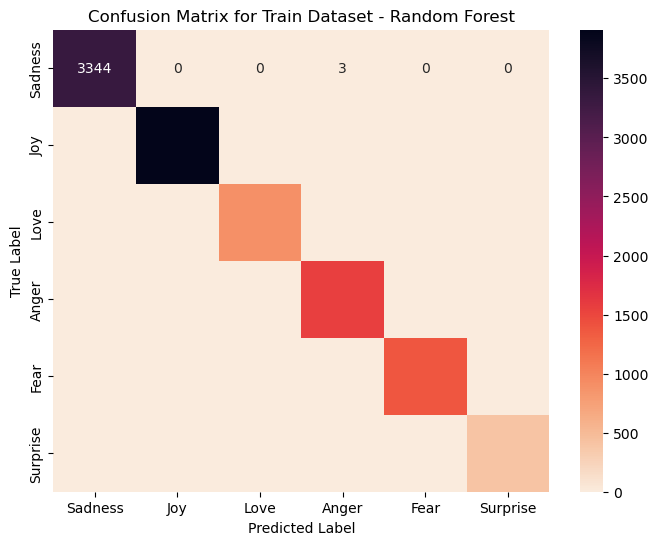

In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(train_rf_con, annot=True, fmt='d', cmap='rocket_r',xticklabels=class_names.values(),yticklabels=class_names.values())
plt.title('Confusion Matrix for Train Dataset - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [39]:
print("Classification Report for Training Dataset:")
print(classification_report(y_train,train_rf,target_names=class_names.values()))

Classification Report for Training Dataset:
              precision    recall  f1-score   support

     Sadness       1.00      1.00      1.00      3347
         Joy       1.00      1.00      1.00      3915
        Love       1.00      0.99      0.99       896
       Anger       1.00      1.00      1.00      1572
        Fear       1.00      1.00      1.00      1382
    Surprise       0.99      1.00      0.99       408

    accuracy                           1.00     11520
   macro avg       1.00      1.00      1.00     11520
weighted avg       1.00      1.00      1.00     11520



In [40]:
test_rf_con= confusion_matrix(y_test, test_rf)
print("Confusion Matrix for Test Dataset:\n", test_rf_con)

Confusion Matrix for Test Dataset:
 [[824  46   9  42  19   6]
 [ 31 922  28  19  12   9]
 [  5 102 174   7   7   1]
 [ 18  29   2 365  12   1]
 [ 16  25   0  25 315  16]
 [  4   9   0   2  20  78]]


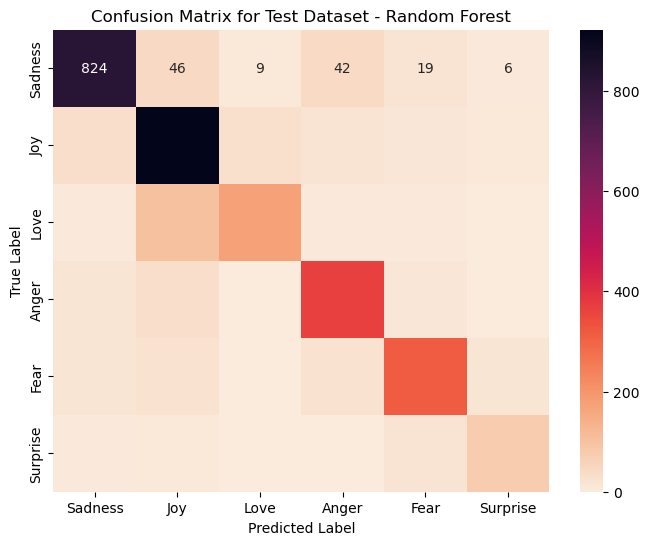

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(test_rf_con, annot=True, fmt='d', cmap='rocket_r',xticklabels=class_names.values(),yticklabels=class_names.values())
plt.title('Confusion Matrix for Test Dataset - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [42]:
print("Classification Report for Test Dataset:")
print(classification_report(y_test,test_rf,target_names=class_names.values()))

Classification Report for Test Dataset:
              precision    recall  f1-score   support

     Sadness       0.92      0.87      0.89       946
         Joy       0.81      0.90      0.86      1021
        Love       0.82      0.59      0.68       296
       Anger       0.79      0.85      0.82       427
        Fear       0.82      0.79      0.81       397
    Surprise       0.70      0.69      0.70       113

    accuracy                           0.84      3200
   macro avg       0.81      0.78      0.79      3200
weighted avg       0.84      0.84      0.83      3200



### Hyeperparameter Tuning

In [43]:
rfc = RandomForestClassifier()

In [44]:
param_grid={'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4] }

In [45]:
rf_grid=GridSearchCV(estimator=rfc,param_grid=param_grid,cv=5,verbose=2,n_jobs=-1)

In [ ]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
rf_grid.best_params_

In [ ]:
rf_grid.best_score_